<figure>
  <IMG SRC="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Fachhochschule_Südwestfalen_20xx_logo.svg/320px-Fachhochschule_Südwestfalen_20xx_logo.svg.png" WIDTH=250 ALIGN="right">
</figure>

# Machine Learning
### Sommersemester 2023
Prof. Dr. Heiner Giefers

## Support Vector Machines und Hauptkomponentenanalyse

Eine *Support Vector Machine* (SVM) ist ein sehr leistungsfähiges und vielseitiges Modell für maschinelles Lernen, mit dem lineare oder nichtlineare Klassifizierung, Regression und sogar Ausreißererkennung durchgeführt werden können. In diesem Notebook werden wir die Umsetzung von SVMs mit Scikit-learn übern. Im Zweiten Teil des Notebooks werden wir die Hauptkomponentenanalyse für die Visualisierung der Daten verwenden.


## Support Vector Machine (SVM)

Support-Vektor-Machines werden vielfach benutzt, weil sie gute Resultate bei relativ geringerem Rechenaufwand liefern. SVMs können sowohl für Regressions- als auch für Klassifikationsaufgaben verwendet werden, wobei die binäre Klassifikation das Haupteinsatzgebiet sind.

Das Ziel des SVM Trainings besteht darin, eine Hyperebene in einem $N$-dimensionalen Raum zu finden, die die Datenpunkte eindeutig klassifiziert. $N$ ist dabei gleich der Anzahl der Merkmale.

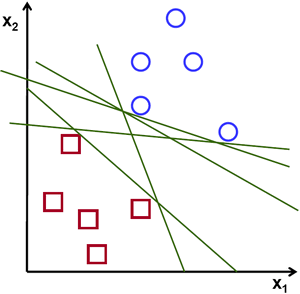 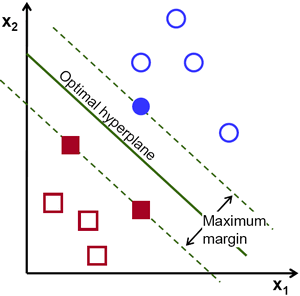

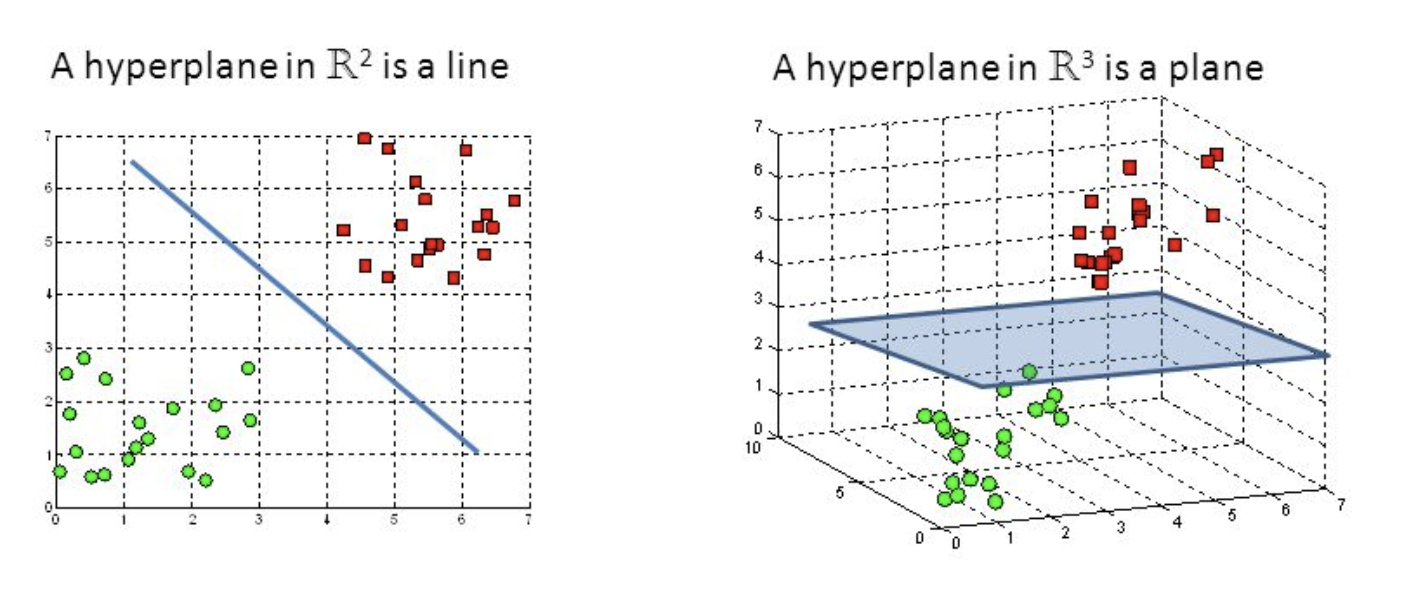
Hyperebenen sind Entscheidungsgrenzen, mit denen die Datenpunkte klassifiziert werden können. Datenpunkte, die auf beide Seiten der Hyperebene fallen, können verschiedenen Klassen zugeordnet werden. Die Dimension der Hyperebene hängt auch von der Anzahl der Merkmale ab. Wenn die Anzahl der Eingabemerkmale 2 beträgt, ist die Hyperebene nur eine Linie. Wenn die Anzahl der Eingabemerkmale 3 beträgt, wird die Hyperebene zu einer zweidimensionalen Ebene im Raum. Für höhere Dimensionen ist die Darstellung der Hyperebenen nicht ohne Weiteres möglich.

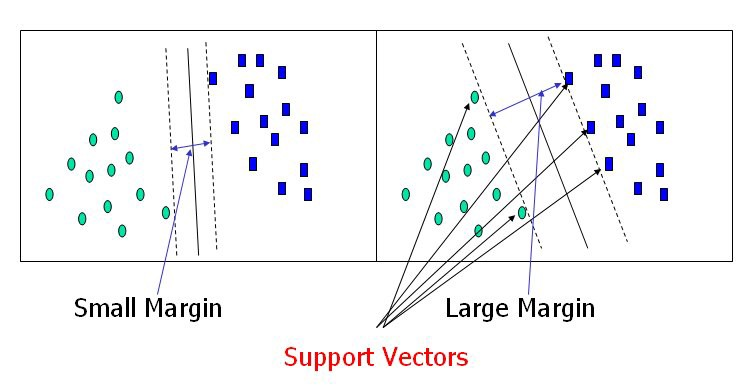

Support Vektoren sind Datenpunkte, die in unmittelbarer Nähe zur Hyperebene liegen und die Position und Ausrichtung der Hyperebene beeinflussen. Mit diesen Support Vektoren maximieren wir den Rand des Klassifikators.

Bei der logistischen Regression nehmen wir die Ausgabe der linearen Funktion und transformieren den Wert in den Bereich von [0,1] mithilfe der Sigmoidfunktion. Wenn der transformierte Wert größer als ein Schwellenwert (i.d.R. $0,5$) ist, weisen wir dem Wert das Resultat $1$ zu, andernfalls weisen wir das Resultat $0$ zu. In SVMs nehmen wir die Ausgabe der linearen Funktion und wenn diese Ausgabe größer als 1 ist, identifizieren wir sie es mit der Klasse $1$ und wenn die Ausgabe kleiner als -1 ist, ordnen wir dem Punkt die Klasse $0$ zu. Da die Schwellenwerte in SVM auf 1 und -1 geändert werden, erhalten wir den Wertebereich [- 1,1] als Pufferzone.

### SVM mit Scikit-learn

In diesem Aufgabenblatt verwenden SVMs für die Vorhersage von Krebsdiagnosen.
Die beiden zu unterscheidenden Klassen sind dabei, ob der Krebs eher *gutartig* oder *bösartig* ist.
Zur vorhersage ziehen wir insgesamt 30 Merkmale hinzu, u.a. die die folgenden:
 - Radius (Mittelwert der Abstände vom Zentrum zu den Punkten am Umfang)
 - Textur (Standardabweichung der Graustufenwerte)
 - Umfang
 - Bereich
 - Glätte (lokale Variation der Radiuslängen)
 - Kompaktheit (Umfang ^ 2 / Fläche - 1,0)
 - Konkavität (Schweregrad der konkaven Teile der Kontur)
 - konkave Punkte (Anzahl der konkaven Teile der Kontur)
 - Symmetrie


Der Datensatz ist mit allen 30 Merkmalen linear trennbar.
Insgesamt enthält der Datensatz 569 Datenpunkte, dovon sind 212 bösartig (engl. *malignant*) und 357 gutartig (engl. *benign*).

In [ ]:
try:
    import seaborn as sns
except:
    import sys
    !{sys.executable} -m pip install seaborn
    
    import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
sns.set_style('whitegrid')

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

col_names = list(cancer.feature_names)
col_names.append(u'target')
df = pd.DataFrame(np.c_[cancer.data, cancer.target], columns=col_names)
df.head()

In [ ]:
print(cancer.target_names)

In [ ]:
df.describe()

In [ ]:
df.info()

### Visualisierung der Daten

Zur Visualisierung der Daten verwenden wir in diesem Arbeitsblatt die *Seaborn* Bibliothek.
Seaborn basiert auf Matplotlib und bietet einige *höhere* Methoden für die optisch ansprechende Darstellung von Statistik-Diagrammen.

In [ ]:
df.columns

`seaborn.pairplot` ist eine *schönere* Variante der `scatter_matrix` Funktion aus der Pandas Bibliothek.

In [ ]:
sns.pairplot(df, hue='target', vars=['mean radius', 'mean texture', 'mean perimeter', 'mean area', 
                                     'mean smoothness', 'mean compactness', 'mean concavity',
                                     'mean concave points', 'mean symmetry', 'mean fractal dimension'])

In [ ]:
sns.countplot(x=df['target'], label = "Count")

Einzelne Feature-Paare können auch über einen Skatter-Plot verglichen werden.

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x = 'mean area', y = 'mean smoothness', hue = 'target', data = df)

Mit `seaborn.heatmap` können wir uns die Korrelationsmatrix der Merkmale als Diagramm anzeigen lassen.

In [ ]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=True) 

### Ein SVM-Modell trainieren

Das Trainingsverhalten eines SVM-Klassifizierer (*Support Vector Machine Classifier*, SVC) kann mit verschiedenen Eingaben parametrisiert werden:

- `C`: Steuert das Verhältnis zwischen der korrekten Klassifizierung von Trainingsdatenpunkten und einer glatten Entscheidungsgrenze. Ein kleines `C` senkt die Kosten für falsch klassifizierte Punkte. Ein größeres `C` erhöht die Kosten für  Fehlklassifizierungen und zwingt das Modell damit, die Eingabedaten starrer zu beschreiben. Letzeres kann also zu einer Überanpassung führen. Mit einem groß gewählten `C`-Wert wird Ihr Modell also *genauer*, neigt damit aber auch zu Overfitting.
- `Gamma`: Steuert, wie weit der Einfluss eines einzelnen Trainingsdatenpunktes reicht. Ein großes Gamma schränkt die Reichweite ein. Damit haben eng zusammen liegende Datenpunkte ein hohes Gewicht. Ein kleines Gamma erhöht die Reichweite. Die Gwichtung von Punkten wird damit weniger Anhängig davon, ob die Punkte gebündelt auftreten oder nicht.
- `Poly`: Grad der Polynomkernfunktion beim Polynomiellen Kernel.


In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

X = df.drop('target', axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

**Aufgabe 1: Lineare Klassifikation** 

Verwenden Sie die Klasse `LinearSVC`, um einen linearen SVM-Klassifizierer zu trainiern. Bewerten Sie die Vorhersagegenauigkeit (*Classification Accuricy*) jeweils auf Grundlage der Trainings- und Testdaten.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

accuracy_train = None
accuracy_test = None

# YOUR CODE HERE
raise NotImplementedError()

print(f"Accuracy (Training): {accuracy_train * 100:.2f}%")
print(f"Accuracy (Test): {accuracy_test * 100:.2f}%")

**Aufgabe 2: Polynomieller Kernel** 

Verwenden Sie die Klasse `SVC`, um einen polyomiellen SVM-Klassifizierer zu trainiern.
Verwenden Sie ein Plynom zweiten Grades, für `gamma` den Wert 0.5, für `coef0` den Wert 1 und für `C` den Wert 5.
Bewerten Sie die Vorhersagegenauigkeit (*Classification Accuricy*) jeweils auf Grundlage der Trainings- und Testdaten.

- `gamma` wird für nichtlineare SVM verwendet und bestimmt, wie weit der Einfluss jeder Stichprobe ist
- Ein Wert von `coef0` ungleich Null führt zu einem nicht-symmetrischen Kernel
- Der `C`-Parameter (Regularisierungsparameter) ist der Grad, zu dem das Modell Fehlklassifizierungen akzeptiert

In [ ]:
from sklearn.svm import SVC

accuracy_train = None
accuracy_test = None

# YOUR CODE HERE
raise NotImplementedError()

print(f"Accuracy (Training): {accuracy_train * 100:.2f}%")
print(f"Accuracy (Test): {accuracy_test * 100:.2f}%")


**Aufgabe 3: Gaußscher RBF-Kernel** 

Verwenden Sie die Klasse `SVC`, um einen SVM-Klassifizierer mit RBF (*Radial Basis Function*) Kernel zu trainiern.
Für `gamma` setzen Sie den Wert 0.5 ein und für `C` den Wert 0.1.
Bewerten Sie die Vorhersagegenauigkeit (*Classification Accuricy*) jeweils auf Grundlage der Trainings- und Testdaten.

In [ ]:
from sklearn.svm import SVC

accuracy_train = None
accuracy_test = None

# YOUR CODE HERE
raise NotImplementedError()

print(f"Accuracy (Training): {accuracy_train * 100:.2f}%")
print(f"Accuracy (Test): {accuracy_test * 100:.2f}%")

### Datenvorverarbeitung für SVMs

Mit dem SVM-Algorithmus finden wir Hyperebenen in unserem mehrdimensionalen Datensatz.
Dabei vergleichen wir die *Abstände* von Punkten im Raum zur betrachteten Hyperebene.
Es ist anschaulich klar, dass es sinnvoll ist, wenn die Abstände der Punkte die gleiche Gewichtung in allen Dimensionen haben.
Wenn ein Merkmal in der Größenordnung von Tausenden ist, ein anderes in der Größenordnung von Hundertsteln, passen die Abstände sicher nicht zu zusammen. Ein Verschiebung hat dann leicht auf das eine Merkmal einen zu geringen, und gleichzeitig auf das das andere Merkmal einen zu hohen Einfluss.
Es ist daher unbedingt ratsam, die Daten vor dem Trainieren des SVM Modells zu normalisieren.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop('target', axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Aufgabe 4: SVM Klassifizierung mit Normalisierten Daten**

Wenden Sie die obigen SVM Klassifikatoren erneut an, nun aber auf Basis der transformierten Daten.
Speichern Sie die Accuracy-Scores in den Listen `accuracy_train` und `accuracy_test`.

In [ ]:
from sklearn.svm import SVC

model_linear = SVC(kernel='linear')
model_poly   = SVC(kernel='poly', degree=2, gamma=0.5, coef0=1, C=5)
model_rbf    = SVC(kernel='rbf', gamma=.5)


def evaluate(X_train, X_test, y_train, y_test, model, label=''):
    # YOUR CODE HERE
    raise NotImplementedError()
    
evaluate(X_train, X_test, y_train, y_test, model_linear, 'Linearer')
evaluate(X_train, X_test, y_train, y_test, model_poly, 'Polynomieller')
evaluate(X_train, X_test, y_train, y_test, model_rbf, 'RBF')



### SVM Hyperparameteroptimierung

Ein üblicher Ansatz, um gute Hyperparameterwerte zu finden, ist die Verwendung der Rastersuche (engl. *grid search*).
Dabei wird für alle Hyperparameterwer eine Reihen von Vorgabewerten definiert, die der Suchalgorithmus dann durchläuft und alle möglichen Kombinationen dieser Parameter durchprobiert.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100],
              'coef0': [0.0, 0.1, 0.5, 1, 2, 10],
              'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'poly', 'linear']} 

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train, y_train)

best_params = grid.best_params_
print(f"Beste Kombination von Parametern: {best_params}")

svm_opt = SVC(**best_params)
evaluate(X_train, X_test, y_train, y_test, svm_opt, 'Best')

## Ausreißererkennung mir SVMs

SVMs können nicht nur zur Klassifikation, sondern auch (für sog. *Einklassenprobleme*) zum erkennen von Anomalien eingesetzt werden.
In diesem Fall wird das Modell so trainiert, dass es lernt, was "normal" ist.
Daten, die außerhalb des *Normalen* liegen, werden als *anomal* eingestuft.

Das Modell `OneClassSVM` aus Scikit-learn kann für die Erkennung von Ausreißern verwendet werden.
`OneClassSVM` verwendet standardmäßig einen Gauß-Kernel (`kernel='rbf'`) und erfordert eine Feinabstimmung des Hyperparameters `nu` um Overfitting zu verhindern.

Im Folgenden Code-Beispiel generieren wir einen *Blob* von Daten und wenden ein `OneClassSVM`-Modell darauf an.
Durch die Wahl des Parameters `nu=0.03` sollen 3% der Daten als Außreißer identifiziert werden.
Außerdem liefert die Standardeinstellung für den Streuungsparameter `gamma` schlechte Ergebnisse, weswegen wir die Policy von `scale` auf `auto` umstellen.

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

X, _ = make_blobs(n_samples=200, centers=1, cluster_std=.3, center_box=(8, 8))

# OneClassSVM Modell initialisieren
model = OneClassSVM(kernel = 'rbf', gamma='auto', nu = 0.03).fit(X)

# Vorhersage
y_pred = model.predict(X)

outlier_index = np.where(y_pred == -1) 
outlier_values = X[outlier_index]

# Streudiagramm mit Ausreißern
plt.scatter(X[:,0], X[:,1])
plt.scatter(outlier_values[:,0], outlier_values[:,1], c = "r");

## Visualisierung mit PCA

Die Hauptkomponentenanalyse (engl. *Principal Component Analysis*, PCA) ist ein Verfahren, das häufig dazu eingesetzt wird hochdimensionale Datensätze zu vereinfachen oder zu visualisieren.
Dazu werden die Merkmale durch eine geringere Anzahzahl möglichst aussagekräftiger Linearkombinationen der Merkmale (den sogenannten Hauptkomponenten) angenähert.

In der Abbildung unten sehen wir zwei Merkmale (*Feature 1* und *2*), sowie die Zielgröße, die über die Farbliche Codierung der Punkte dargestellt wird.
Die erste Hauptkomponente liegt ca. entlang der Diagonalen von links oben nach rechts unten im Diagramm. Mathematisch gesehen, weisen die Punkte entlang dieser Achse die größte Streuung auf. Die zweite Hauptkomponente liegt orthogonal zur ersten. Hierauf Weisen die Punkte eine geringere Streuung auf.

Legt man nun die die Hauptkomponenten entlang der $x$- und $y$-Achse des Koordinatensystems an, gelangt man zur Abbildung oben rechts. Entfernt man aus diesen Daten die Werte entlang der zweiten Hauptkomponente, kommt man zur Abbildung unten links.
Durch eine Rücktransformation mit der ersten Hauptkomponente entsteht die Abbildung unten rechts. Man sieht, dass diese vereinfachten Daten (statt zwei Variablen, besteht dieser Datensatz nur aus einer einer Variablen) den AUsgangsdatensatz recht gut abbilden.



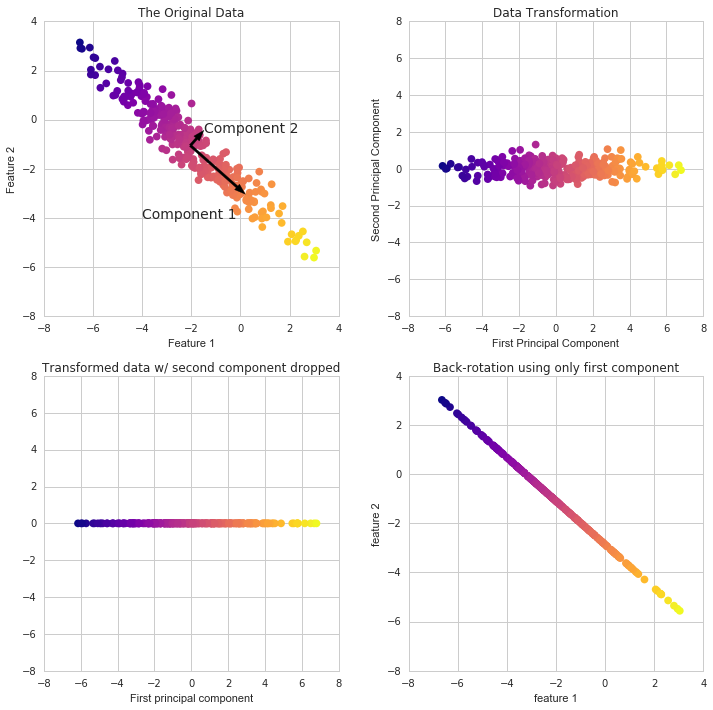

Wie bereits angesprochen, ist es schwierig, hochdimensionale Daten zu visualisieren.
Mithilfe ist der PCA ist es nun möglich, die ersten beiden Hauptkomponenten eines Datensatzes zu ermitteln, und die auf diese beiden Hauptkomponenten transformierten Daten in einem zweidimensionalen Koordinatensystem als Streudiagramm darzustellen.

**Aufgabe 5: Standardisierung**

Auch bei der PCA ist ein Normalisieren der Daten notwendig.
Verwenden Sie den `StandardScaler` aus *Scikit-learn*, um die Daten zu Standardisieren. Die transformierten Merkmale (vor Verwendung der PCA) eine einheitliche Standardabweichung von 1 ausweisen.

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

X_transform = None

X = df.drop('target', axis=1)
y = df.target

# YOUR CODE HERE
raise NotImplementedError()

X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.3, random_state=1)

In [ ]:
assert np.sum((np.std(X_train, axis=0)-1)**2)<0.2

Die PCA in *Scikil-learn* funktioniert wie andere Transomatoren (z.B. `StandardScaler` oder `MinMaxScaler`) auch.
Bei der Initialisierung des der `PCA`-Instanz kann man die Anzahl der Hauptkomponenten angeben, die bei der Transformation beibehalten werden sollen.

**Aufgabe 6: PCA durchführen**
Verwenden die Klasse PCA aus *Scikil-learn*, um den Datensatz von ursprünglich 30 auf 3 Merkmale zu reduzieren

In [ ]:
from sklearn.decomposition import PCA

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert X_test.shape[1]==X_train.shape[1]==3

Nun können wir die Daten in der Ebene visualisieren.

In [ ]:
from sklearn.decomposition import PCA

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

## Beispiel: Eigenfaces

Am Beispiel der *Eigenfaces* wollen wir untersuchen, wie mittels der Hauptkomponentenanalyse Daten in der Praxis reduziert werden können, ohne allzuviel Information dabei zu verlieren. Im Grunde kann man das Verfahren so acu als (verlustbehaftete) Komression auffassen.

Der [*Labeled Faces in the Wild*](http://vis-www.cs.umass.edu/lfw/) Datensatz enthält Portraitbilder bekannter Persönlichkeiten und ist über die Scikit-Learn Bibliothek verfügbar.
Wir wollen diesen Datensatz verwenden, um Bilddaten mittes der Hauptkomponentenanalyse zu komprimieren.

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50)
print(faces.target_names)
print(faces.images.shape)

Betrachten wir nun die Hauptkomponenten der einzelnen Bilder.
Da es sich um einen großen Datensatz handelt, werden wir das Verfaheren `RandomizedPCA` verwenden - es enthält eine randomisierte Methode, um die ersten $N$ Hauptkomponenten viel schneller als der Standard-PCA-Schätzer zu approximieren und ist daher sehr nützlich für hochdimensionale Daten (hier eine Dimensionalität von fast 3.000). Wir können nun die ersten 150 Komponenten berechnen:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(150, svd_solver='randomized')
pca.fit(faces.data)

In diesem Fall kann es interessant sein, die Bilder zu visualisieren, die mit den ersten paar Hauptkomponenten verbunden sind (diese Komponenten werden technisch als "Eigenvektoren" bezeichnet, daher werden diese Art von Bildern oft als "Eigenfaces" bezeichnet).

In [ ]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(3, 8, figsize=(15, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Die Ergebnisse geben uns Einblicke, wie sich die Bilder unterscheiden: Zum Beispiel scheinen die ersten paar Eigenfaces (oben links) mit dem Lichteinfallswinkel auf das Gesicht verbunden zu sein, während andere Hauptvektoren bestimmte Merkmale wie Augen, Nasen und Lippen auswählen.
Lassen Sie uns einen Blick auf die kumulative Varianz dieser Komponenten werfen, um zu sehen, wie viel der Dateninformation die Projektion beibehält:

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Wir sehen, dass diese 150 Komponenten etwas mehr als 90% der Varianz ausmachen.
Das würde uns glauben lassen, dass wir mit diesen 150 Komponenten die meisten wesentlichen Merkmale der Daten wiederherstellen würden.
Um dies konkreter zu machen, können wir die Eingangsbilder mit den aus diesen 150 Komponenten rekonstruierten Bildern vergleichen:

In [ ]:
# Compute the components and projected faces
pca = PCA(150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

In [ ]:
import random
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(15, 4),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
ids = random.sample(range(len(faces.data)), 10)
for i in range(10):
    ax[0, i].imshow(faces.data[ids[i]].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[ids[i]].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

Die obere Reihe zeigt hier die Eingangsbilder, während die untere Reihe die Rekonstruktion der Bilder aus nur 150 der ~3.000 ursprünglichen Merkmale zeigt. Obwohl die Dimensionalität der Daten um fast einen Faktor von 20 reduziert wird, enthalten die projizierten Bilder genügend Informationen, um die Personen auf den Bildern erkennen zu können.
Das bedeutet, dass ein Klassifikationsalgorithmus nun mit 150-dimensionale Daten statt auf 3.000-dimensionale Daten trainiert werden kann, was je nach gewähltem Algorithmus zu einer wesentlich effizienteren Klassifizierung führen kann.


### Referenzen:

- Fares Sayah, [*Support Vector Machine & PCA Tutorial for Beginner*](https://www.kaggle.com/faressayah/support-vector-machine-pca-tutorial-for-beginner), Eintrag auf Kaggle.com, 2021 (abgerufen am 14.05.2021)
- Rohith Gandhi, [*Support Vector Machine - Introduction to Machine Learning Algorithms*](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)
Artikel auf towardsdatascience.com, 2018 (abgerufen am 14.05.2021)
- [*Scikit-learn - Support Vector Machines*](https://scikit-learn.org/stable/modules/svm.html#svm-kernels)
- [*Scikit-learn - Dekomposition mit PCA*](http://scikit-learn.org/stable/modules/decomposition.html#pca)
- [Mahbubul Alam, *Support Vector Machine (SVM) for Anomaly Detection*, Towards Data Science, 2020](https://towardsdatascience.com/support-vector-machine-svm-for-anomaly-detection-73a8d676c331)
